In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define constants
IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 16
SEED = 12
LEARNING_RATE = 0.0001
EPOCHS = 60
BASE_DIR = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
PROCESSED_DIR = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/processed_dataset'
SAVED_TEST_DATA_DIR = '/content/drive/MyDrive/saved_test_data'

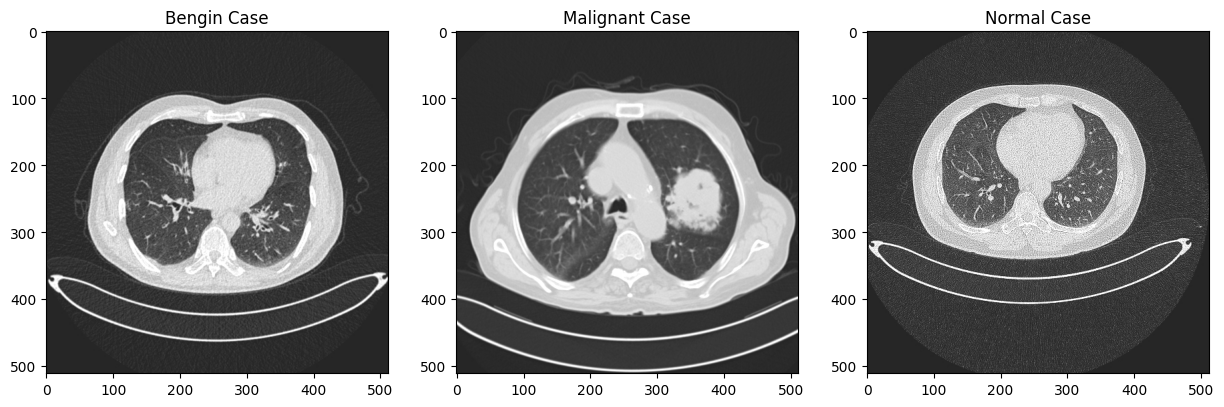

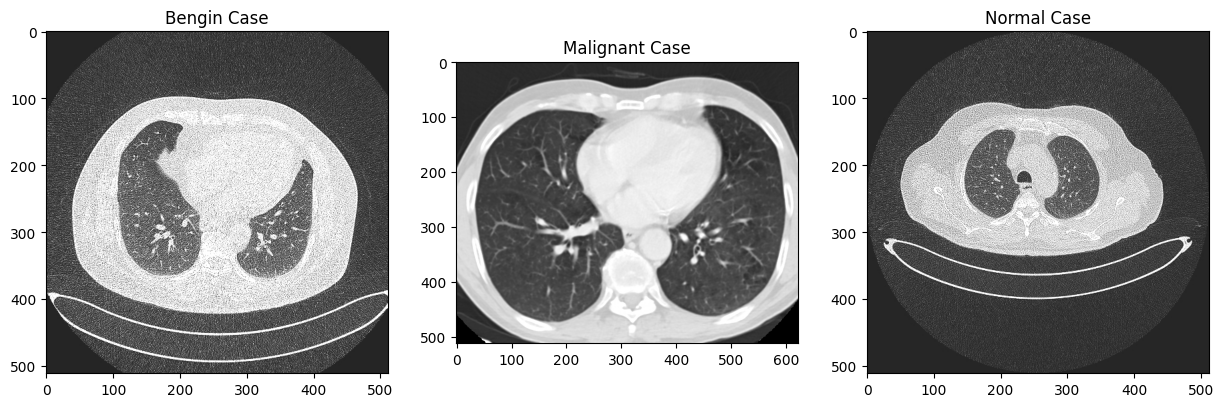

In [ ]:
def visualize_samples(image_paths, titles):
    plt.figure(figsize=(15, 5))
    for i, (image_path, title) in enumerate(zip(image_paths, titles)):
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error loading image at {image_path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        plt.title(title)
    plt.show()

image_paths_1 = [
        os.path.join(BASE_DIR, 'Bengin cases/Bengin case (10).jpg'),
        os.path.join(BASE_DIR, 'Malignant cases/Malignant case (10).jpg'),
        os.path.join(BASE_DIR, 'Normal cases/Normal case (100).jpg')
    ]

image_paths_2 = [
        os.path.join(BASE_DIR, 'Bengin cases/Bengin case (101).jpg'),
        os.path.join(BASE_DIR, 'Malignant cases/Malignant case (251).jpg'),
        os.path.join(BASE_DIR, 'Normal cases/Normal case (109).jpg')
    ]
titles = ['Bengin Case', 'Malignant Case', 'Normal Case']
# Visualize the sample images
visualize_samples(image_paths_1, titles)
visualize_samples(image_paths_2, titles)


In [ ]:
def preprocess_and_save_images(base_dir, processed_dir, img_width, img_height):
    categories = ['Malignant cases', 'Bengin cases', 'Normal cases']

    # Create directories to save processed images
    for category in categories:
        os.makedirs(os.path.join(processed_dir, category), exist_ok=True)

    for category in categories:
        category_path = os.path.join(base_dir, category)
        save_path = os.path.join(processed_dir, category)
        for fname in os.listdir(category_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(category_path, fname)
                img = cv2.imread(img_path)
                img_resized = cv2.resize(img, (img_width, img_height))  # Resize image
                # img_rescaled = img_resized / 255.0  # Rescale image
                save_img_path = os.path.join(save_path, fname)
                cv2.imwrite(save_img_path, img)  # Save the image as an 8-bit image

preprocess_and_save_images(BASE_DIR, PROCESSED_DIR, IMG_WIDTH, IMG_HEIGHT)

In [ ]:
# # Manually split the dataset
# def load_and_split_dataset():
#     image_files = []
#     labels = []

#     categories = ['Malignant cases', 'Bengin cases', 'Normal cases']
#     for category in categories:
#         category_path = os.path.join(BASE_DIR, category)
#         for fname in os.listdir(category_path):
#             if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
#                 image_files.append(os.path.join(category_path, fname))
#                 labels.append(category.split(' ')[0].lower())  # Malignant, Benign, Normal

#     image_files = np.array(image_files)
#     labels = np.array(labels)

#     train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=45, stratify=labels)
#     train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.25, random_state=45, stratify=train_labels)  # 0.25 x 0.8 = 0.2

#     return train_files, val_files, test_files, train_labels, val_labels, test_labels


In [ ]:
def save_test_data(test_files, test_labels):
    os.makedirs(SAVED_TEST_DATA_DIR, exist_ok=True)
    label_map = {'malignant': 'Malignant', 'bengin': 'Benign', 'normal': 'Normal'}

    # Save each test image and its label
    for i, (file, label) in enumerate(zip(test_files, test_labels)):
        img = cv2.imread(file)
        label_dir = os.path.join(SAVED_TEST_DATA_DIR, label_map[label])
        os.makedirs(label_dir, exist_ok=True)
        save_path = os.path.join(label_dir, f'test_img_{i}.jpg')
        cv2.imwrite(save_path, img)

    print(f"Saved {len(test_files)} test images and labels to {SAVED_TEST_DATA_DIR}")


In [ ]:
def load_and_split_dataset(processed_dir):
    image_files = []
    labels = []

    categories = ['Malignant cases', 'Bengin cases', 'Normal cases']
    for category in categories:
        category_path = os.path.join(processed_dir, category)
        for fname in os.listdir(category_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(category_path, fname))
                labels.append(category.split(' ')[0].lower())  # malignant, benign, normal

    image_files = np.array(image_files)
    labels = np.array(labels)

    train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42, stratify=labels)
    train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.3, random_state=42, stratify=train_labels)  # 0.25 x 0.8 = 0.2

    save_test_data(test_files, test_labels)
    return train_files, val_files, test_files, train_labels, val_labels, test_labels


train_files, val_files, test_files, train_labels, val_labels, test_labels = load_and_split_dataset(PROCESSED_DIR)  # Step 2: Load and split


Saved 220 test images and labels to /content/drive/MyDrive/saved_test_data


In [ ]:
def create_data_generators(train_files, val_files, test_files, train_labels, val_labels, test_labels):
    train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})
    test_df = pd.DataFrame({'filename': test_files, 'class': test_labels})

    print("Train df: ", train_df["class"].value_counts())
    print("Val df: ", val_df["class"].value_counts())
    print("Test df: ", test_df["class"].value_counts())

    # train_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling as images are already preprocessed

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input
        # rotation_range=10,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # shear_range=0.1,
        # zoom_range=0.1,
    )

    train_data = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)
    val_data = val_test_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    test_data = val_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col='class',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_data, val_data, test_data

train_data, val_data, test_data = create_data_generators(train_files, val_files, test_files, train_labels, val_labels, test_labels)  # Step 3: Create generators

Train df:  class
malignant    313
normal       233
bengin        67
Name: count, dtype: int64
Val df:  class
malignant    135
normal       100
bengin        29
Name: count, dtype: int64
Test df:  class
malignant    113
normal        83
bengin        24
Name: count, dtype: int64
Found 613 validated image filenames belonging to 3 classes.
Found 264 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
# # Data generators
# def create_data_generators(train_files, val_files, test_files, train_labels, val_labels, test_labels):
#     train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
#     val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})
#     test_df = pd.DataFrame({'filename': test_files, 'class': test_labels})

#     # train_datagen = ImageDataGenerator(rescale=1./255)

#     train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         # rotation_range=10,
#         # width_shift_range=0.1,
#         # height_shift_range=0.1,
#         # shear_range=0.1,
#         # zoom_range=0.1,
#     )

#     val_test_datagen = ImageDataGenerator(rescale=1./255)

#     train_data = train_datagen.flow_from_dataframe(
#         dataframe=train_df,
#         x_col='filename',
#         y_col='class',
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         shuffle=True,
#         seed=SEED
#     )

#     val_data = val_test_datagen.flow_from_dataframe(
#         dataframe=val_df,
#         x_col='filename',
#         y_col='class',
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         shuffle=True,
#         seed=SEED
#     )

#     test_data = val_test_datagen.flow_from_dataframe(
#         dataframe=test_df,
#         x_col='filename',
#         y_col='class',
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         shuffle=False  # No shuffling for the test set to maintain order
#     )

#     return train_data, val_data, test_data


In [ ]:
# # Load dataset
# def load_dataset():
#     train_datagen = ImageDataGenerator(
#       rescale=1./255,
#       rotation_range=10,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       shear_range=0.1,
#       zoom_range=0.1,
#       horizontal_flip=True,
#       validation_split=0.4  # 40% for validation and testing combined
#     )

#     train_data = train_datagen.flow_from_directory(
#         BASE_DIR,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         subset='training',
#         seed=SEED
#     )

#     # Load validation data
#     val_data = train_datagen.flow_from_directory(
#         BASE_DIR,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         subset='validation',
#         seed=SEED
#     )

#     test_datagen = ImageDataGenerator(
#         rescale=1./255,
#         validation_split=0.2  # Use 20% of the data for testing
#     )

#     test_data = test_datagen.flow_from_directory(
#         BASE_DIR,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         subset='validation',
#         seed=SEED,
#         shuffle=False  # No shuffling for the test set to maintain order
#     )
#     return train_data, val_data, test_data
#     # train_data = image_dataset_from_directory(
#     #     base_dir,
#     #     label_mode="categorical",
#     #     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     #     batch_size=BATCH_SIZE,
#     #     shuffle=True,
#     #     seed=SEED,
#     #     validation_split=0.3,
#     #     subset="training"
#     # )
#     # val_data = image_dataset_from_directory(
#     #     base_dir,
#     #     label_mode="categorical",
#     #     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     #     batch_size=BATCH_SIZE,
#     #     shuffle=True,
#     #     seed=SEED,
#     #     validation_split=0.2,
#     #     subset="validation"
#     # )
#     # test_data = image_dataset_from_directory(
#     #     base_dir,
#     #     label_mode="categorical",
#     #     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     #     batch_size=BATCH_SIZE,
#     #     shuffle=True,
#     #     seed=SEED,
#     #     validation_split=0.1,
#     #     subset="validation"
#     # )
#     # return train_data, val_data, test_data

In [ ]:
# Build model
def build_model():
    model = Sequential([
        Conv2D(128, (2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
        BatchNormalization(),
        AvgPool2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),


        Dense(3, activation='softmax'),


    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.SGD(learning_rate=LEARNING_RATE),
        metrics=['accuracy']
    )
    return model

model = build_model()  # Step 4: Build model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 128)       │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,225,731 (35.19 MB)

 Trainable params: 9,224,835 (35.19 MB)

 Non-trainable params: 896 (3.50 KB)

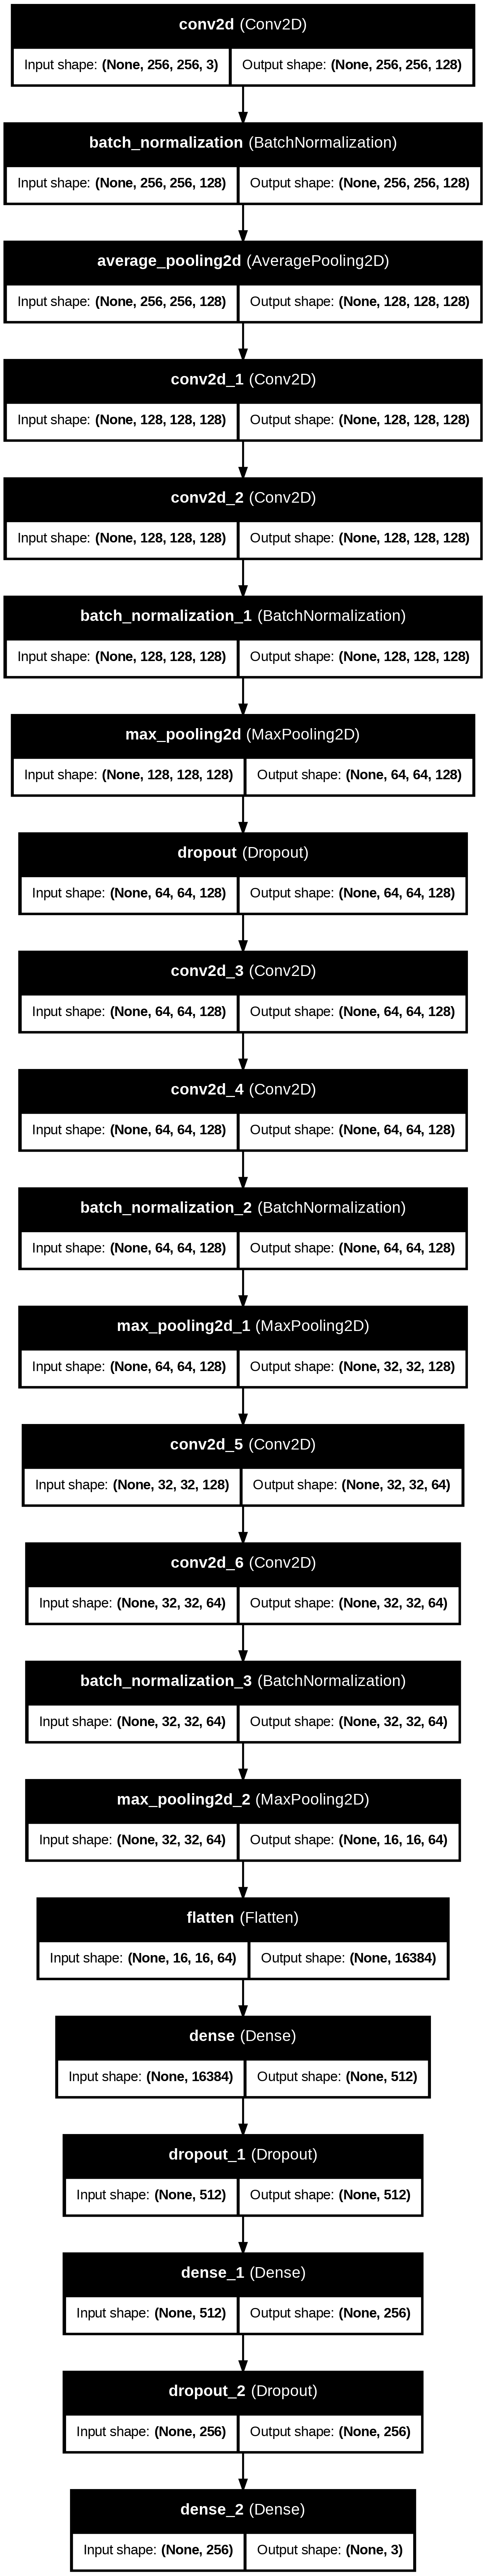

In [ ]:
plot_model(model,
           to_file='/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/processed_datasetmodel_plot.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
# def build_model():
#     model = Sequential()

#     # First convolutional block
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))

#     # Second convolutional block
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))

#     # Third convolutional block
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))

#     # Fourth convolutional block
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))

#     # Fully connected layers
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))  # Increase dropout to reduce overfitting
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))  # Dropout again for more regularization

#     # Output layer
#     model.add(Dense(3, activation='softmax'))  # 3 output classes

#     # Compile the model
#     model.compile(
#         loss='categorical_crossentropy',
#         optimizer=Adam(learning_rate=LEARNING_RATE),
#         metrics=['accuracy']
#     )

#     return model

# model = build_model()  # Step 4: Build model
# model.summary()

In [ ]:
# Train model
from tensorflow.keras.callbacks import ReduceLROnPlateau

def train_model(model, train_data, val_data):
    reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, mode='max', verbose=1)
    checkpoint_path = '/content/drive/MyDrive/saved_model/best_model.keras'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=[early_stopping,checkpoint]
    )
    return history, checkpoint_path

history, checkpoint_path = train_model(model, train_data, val_data)  # Step 5: Train model
best_model = load_model(checkpoint_path)

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.3722 - loss: 1.8948
Epoch 1: val_accuracy improved from -inf to 0.51136, saving model to /content/drive/MyDrive/saved_model/best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 626ms/step - accuracy: 0.3742 - loss: 1.8880 - val_accuracy: 0.5114 - val_loss: 1.0533
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5048 - loss: 1.2543
Epoch 2: val_accuracy did not improve from 0.51136
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.5054 - loss: 1.2538 - val_accuracy: 0.5114 - val_loss: 1.0125
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5659 - loss: 1.1428
Epoch 3: val_accuracy did not improve from 0.51136
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.5660 - loss: 1.1418 - val_accuracy: 0.5114 - val_loss: 0.9824
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6225 - loss: 0.9744
Epoch 4: val_accuracy improved from 0.51136 to 0.58712, saving model to /content/

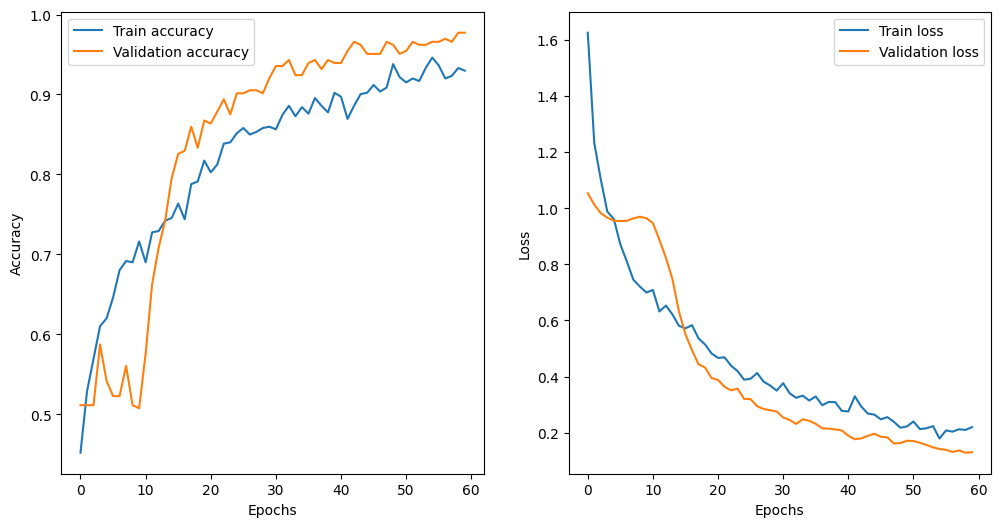

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_history(history)

In [ ]:
# Plot confusion matrix
# def plot_confusion_matrix(y_true, y_pred, class_names):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     tick_marks = np.arange(len(class_names))
#     plt.xticks(tick_marks, class_names, rotation=45)
#     plt.yticks(tick_marks, class_names)

#     fmt = 'd'
#     for i, j in enumerate(cm):
#         for k, val in enumerate(j):
#             plt.text(k, i, format(val, fmt), horizontalalignment="center", color="black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

In [ ]:
def evaluate_model(model, test_data):
    loss, acc = model.evaluate(test_data)
    print(f'\nTest Accuracy = {acc}\nTest Loss = {loss}')
evaluate_model(best_model, test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.9671 - loss: 0.1435

Test Accuracy = 0.9727272987365723
Test Loss = 0.13456016778945923


In [ ]:
labels = train_data.class_indices
labels

{'bengin': 0, 'malignant': 1, 'normal': 2}

In [ ]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.show()


In [ ]:
# Extract true labels efficiently
def extract_labels(generator):
    labels = []
    for _, y_batch in generator:
        labels.append(y_batch)
        # Break loop if you have processed all batches
        if len(labels) * generator.batch_size >= generator.samples:
            break
    # Concatenate all labels into a single array
    y_true = np.concatenate(labels, axis=0)
    return y_true



14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.92      0.96        24
   Malignant       0.97      0.99      0.98       113
      Normal       0.96      0.96      0.96        83

    accuracy                           0.97       220
   macro avg       0.98      0.96      0.97       220
weighted avg       0.97      0.97      0.97       220



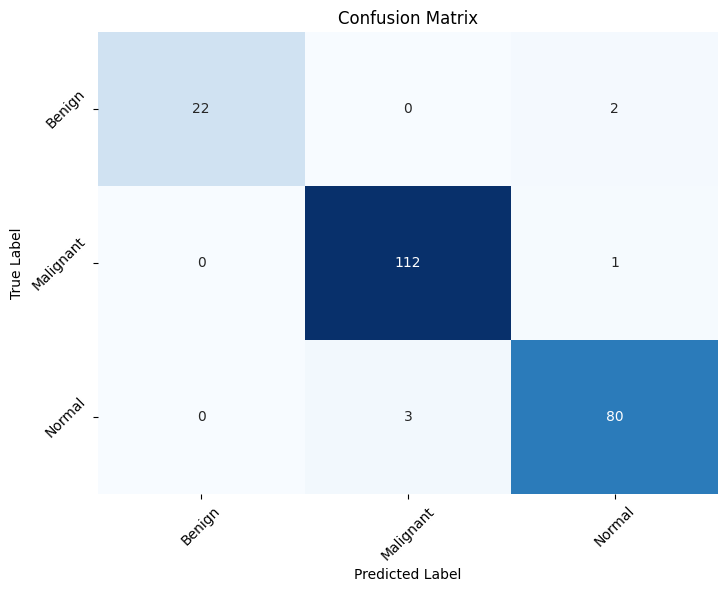

In [ ]:
# Step 7: Predict and Evaluate Performance
def predict_and_evaluate(model, test_data):

    # Get true labels from test_data
    y_true = extract_labels(test_data)

    # Convert one-hot encoded labels to class indices
    y_true_classes = np.argmax(y_true, axis=1)
    # Predict and evaluate performance
    y_pred = best_model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)

    class_names = ['Benign', 'Malignant', 'Normal']
    print('\nClassification Report:')
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
predict_and_evaluate(best_model, test_data)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.92      0.96        24
   Malignant       0.97      0.99      0.98       113
      Normal       0.96      0.96      0.96        83

    accuracy                           0.97       220
   macro avg       0.98      0.96      0.97       220
weighted avg       0.97      0.97      0.97       220

Precision: 0.9729644268774703
Specificity: 0.9792561550550026
AUC-ROC: 0.9949566591634946
AUC-PR: 0.9921823147174319


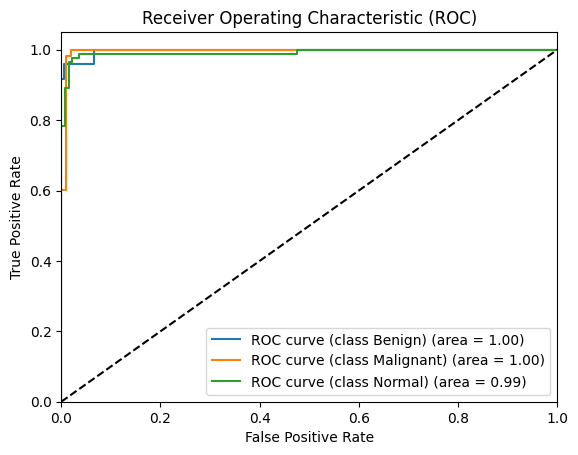

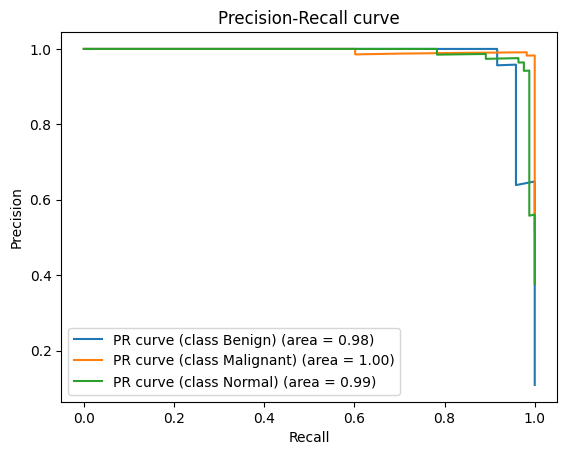

In [ ]:
from sklearn.metrics import precision_score, roc_auc_score, average_precision_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    true_negatives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_negatives
    specificity = true_negatives / (true_negatives + false_positives)
    return np.mean(specificity)

def evaluate_extended_metrics(y_true_classes, y_pred_classes, y_pred_probs):
    # Precision
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    print(f'Precision: {precision}')

    # Specificity
    specificity = specificity_score(y_true_classes, y_pred_classes)
    print(f'Specificity: {specificity}')

    # AUC-ROC
    auc_roc = roc_auc_score(y_true_classes, y_pred_probs, multi_class='ovr')
    print(f'AUC-ROC: {auc_roc}')

    # AUC-PR
    auc_pr = average_precision_score(y_true_classes, y_pred_probs, average='weighted')
    print(f'AUC-PR: {auc_pr}')

    # Plot AUC-ROC
    plot_auc_roc(y_true_classes, y_pred_probs)

    # Plot AUC-PR
    plot_auc_pr(y_true_classes, y_pred_probs)

def plot_auc_roc(y_true_classes, y_pred_probs):
    from sklearn.metrics import roc_curve, auc

    fpr = {}
    tpr = {}
    roc_auc = {}
    class_names = ['Benign', 'Malignant', 'Normal']
    # Compute ROC curve and ROC area for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_classes == i, y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {class_names[i]}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def plot_auc_pr(y_true_classes, y_pred_probs):
    from sklearn.metrics import precision_recall_curve, average_precision_score

    precision = {}
    recall = {}
    pr_auc = {}

    # Compute Precision-Recall curve and AUC for each class
    class_names = ['Benign', 'Malignant', 'Normal']
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_classes == i, y_pred_probs[:, i])
        pr_auc[i] = average_precision_score(y_true_classes == i, y_pred_probs[:, i])

    # Plot all PR curves
    plt.figure()
    for i in range(len(class_names)):
        plt.plot(recall[i], precision[i], label=f'PR curve (class {class_names[i]}) (area = {pr_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def predict_and_evaluate_extended(model, test_data):
    # Get true labels from test_data
    y_true = extract_labels(test_data)
    y_true_classes = np.argmax(y_true, axis=1)

    # Predict and get probabilities
    y_pred = best_model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_pred_probs = y_pred  # Probabilities for AUC-ROC and AUC-PR

    class_names = ['Benign', 'Malignant', 'Normal']
    print('\nClassification Report:')
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Evaluate extended metrics
    evaluate_extended_metrics(y_true_classes, y_pred_classes, y_pred_probs)

# Call the extended evaluation function
predict_and_evaluate_extended(best_model, test_data)


In [ ]:

from tensorflow.keras.models import load_model

# Load the .keras model
best_model = load_model('/content/drive/MyDrive/saved_model/best_model.keras')

# Save the model as .h5 format
best_model.save('/content/drive/MyDrive/saved_model/lung_ct_model.h5')


In [ ]:
best_model.save

ModuleNotFoundError: No module named 'streamlit'